In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pytomography
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from spectpsftoolbox.simind_io import get_projections, get_radii
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata, subsample_amap
from spectpsftoolbox.operator2d import NearestKernelOperator
device = pytomography.device

This tutorial looks at reconstructing Lu177 data acquired with a low energy (as opposed to a typical medium energy) collimator. First, we open some point source data of 208keV photons impinging on a medium energy collimator:

In [11]:
headerpaths = np.array([f'/disk1/psf_data/208keV_LE_PSF/point_position{i}_tot_w1.h00' for i in range(538,1638)])
respaths = np.array([f'/disk1/psf_data/208keV_LE_PSF/point_position{i}.res' for i in range(538,1638)])
distances = get_radii(respaths).to(device)
projectionss_data = get_projections(headerpaths).to(device)[:,1:,1:]

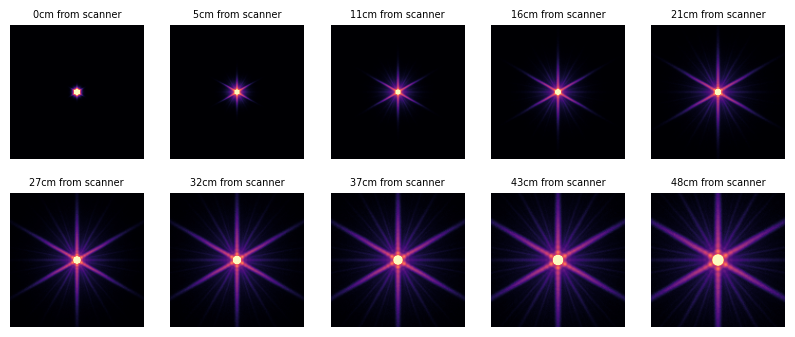

In [12]:
fig, ax = plt.subplots(2,5,figsize=(10,4))
for i, IDX in enumerate([0,100,200,300,400,500,600,700,800,900]):
    plt.sca(ax.ravel()[i])
    plt.imshow(projectionss_data[IDX].cpu().numpy(), cmap='magma', vmax=projectionss_data[IDX].cpu().numpy().max()/10)
    plt.title(f'{distances[IDX].item():.0f}cm from scanner', fontsize=7)
    plt.axis('off')

Let's create a kernel out of this:

In [13]:
projectionss_data /= projectionss_data[0:100].sum().reshape(-1,1,1) / 100
psf_operator = NearestKernelOperator(
    psf_data = projectionss_data,
    distances = distances,
    dr0 = (0.48,0.48)
)

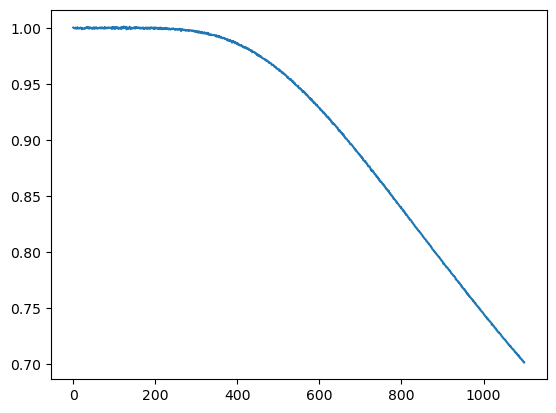

In [16]:
plt.plot(projectionss_data.sum(dim=(1,2)).cpu())

Let's perform PyTomography reconstruction. We'll get all the necessary data:

In [5]:
activity = 1000 # MBq
dT = 15 # seconds per projection

paths = [f'/disk1/psf_data/208keV_LE_jaszak/tot_w{i}.h00' for i in range(1,4)]
object_meta, proj_meta = simind.get_metadata(paths[0])
projections = simind.get_projections(paths)
projections = torch.poisson(activity*dT*projections)

object_meta, proj_meta, projections = subsample_projections_and_modify_metadata(object_meta, proj_meta, projections, N_pixel = 2, N_angle=1)
photopeak = projections[1]
ww_peak = simind.get_energy_window_width(paths[1])
ww_lower = simind.get_energy_window_width(paths[0])
ww_upper = simind.get_energy_window_width(paths[2])
lower_scatter = projections[0]
upper_scatter = projections[2]
scatter = (lower_scatter/ww_lower+upper_scatter/ww_upper)*ww_peak/2
attenuation_path = '/disk1/psf_data/208keV_LE_jaszak/amap.hct'
attenuation_map = simind.get_attenuation_map(attenuation_path)
attenuation_map = subsample_amap(attenuation_map, 2)
att_transform = SPECTAttenuationTransform(attenuation_map)


We'll reconstruct using OSEM(20it,8ss).

Reconstruction using standard PSF modeling:

In [6]:
psf_meta = simind.get_psfmeta_from_header(paths[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta
    )
likelihood = PoissonLogLikelihood(system_matrix, projections[1], additive_term=scatter)
recon_algorithm = OSEM(likelihood)
recon_BASIC = recon_algorithm(n_iters = 40, n_subsets = 8)

Recon using Monte Carlo PSF:

In [7]:
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    proj2proj_transforms = [],
    object_meta = object_meta,
    proj_meta = proj_meta
    )
likelihood = PoissonLogLikelihood(system_matrix, projections[1], additive_term=scatter)
recon_algorithm = OSEM(likelihood)
recon_MONTECARLO = recon_algorithm(n_iters = 40, n_subsets = 8)

Compare the two:

(34.0, 94.0, 34.0, 94.0)

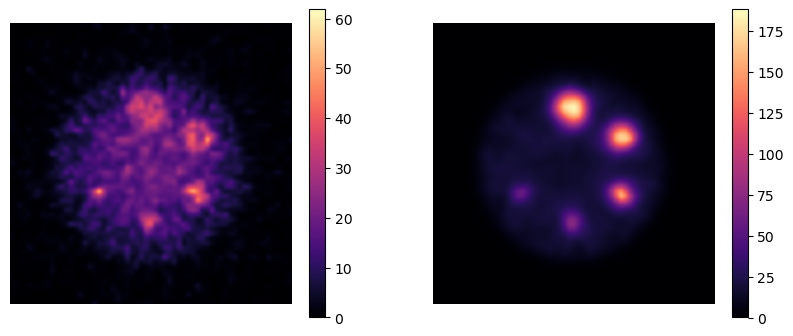

In [8]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt.imshow(recon_BASIC[:,:,64].cpu().T, cmap='magma', interpolation='gaussian')
plt.xlim(64-30, 64+30)
plt.ylim(64-30, 64+30)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
plt.imshow(recon_MONTECARLO[:,:,64].cpu().T, cmap='magma', interpolation='gaussian')
plt.xlim(64-30, 64+30)
plt.ylim(64-30, 64+30)
plt.colorbar()
plt.axis('off')

In [9]:
torch.save(recon_BASIC, '/disk1/psf_data/toolbox_plots_data/lu177_le_badPSF_40it8ss.pt')
torch.save(recon_MONTECARLO, '/disk1/psf_data/toolbox_plots_data/lu177_le_goodPSF_40it8ss.pt')

The one that uses the Monte Carlo kernels for PSF modeling is much better.